# Preprocessing fossil data

Gabriel Munoz  
September 27, 2024

In [ ]:
library(dplyr)



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Linking to GEOS 3.11.2, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

## Fossil data

We will use a cut of the NOW database, kindly provided by `Shan`

In [ ]:
fossil <- read.csv("DATA/NOW_filtered_by_Shan_Oct2019.csv")

# subset only the data we need 

fossil <- fossil |> 
  select(LIDNUM, GENUS, SPECIES, FAMILY, ORDER, MIN_AGE, MAX_AGE, LONG, LAT)


Let’s examine a summary of the dataset

In [ ]:
gtsummary::tbl_summary(fossil, 
                       include = c('ORDER', 'MAX_AGE', 'MIN_AGE'))


### Spatio-temporal data coverage

Let’s examine the spatiotemporal extent of the dataset, and filter according to our needs.

First, lets create two new columns, `time_period_min` and `time_period_max` to assign categorical time periods based on the estimated radiocarbon data.

In [ ]:
## define a function to assign time periods based on literature thresholds 

change_time_to_period <- function(MIN_AGE){
  case_when(round(MIN_AGE) %in% c(21:23) ~ 'Aquitanian',  
            round(MIN_AGE) %in% c(16:20) ~ 'Burdigalian',
            round(MIN_AGE) %in% c(14:15) ~ 'Langhian',
            round(MIN_AGE) %in% c(12:13) ~ 'Serravallian',
            round(MIN_AGE) %in% c(11:8) ~ 'Tortonian',
            round(MIN_AGE) %in% c(5:7) ~ 'Messinian',
            round(MIN_AGE) %in% c(4:5) ~ 'Zanclean',
            round(MIN_AGE) %in% c(2:3) ~ 'Piacenzian')     
  
  
}

change_period_to_midpoint <- function(period) {
  case_when(
    period == 'Aquitanian'  ~ mean(c(21, 23)),
    period == 'Burdigalian' ~ mean(c(16, 20)),
    period == 'Langhian'    ~ mean(c(14, 15)),
    period == 'Serravallian' ~ mean(c(12, 13)),
    period == 'Tortonian'   ~ mean(c(8, 11)),
    period == 'Messinian'   ~ mean(c(5, 7)),
    period == 'Zanclean'    ~ mean(c(4, 5)),
    period == 'Piacenzian'  ~ mean(c(2, 3)),
    TRUE ~ NA_real_  # Return NA if no match
  )
}


In [ ]:
## apply the function

fossil <- 
  fossil |> 
  mutate(
    time_period_max = change_time_to_period(MAX_AGE), 
    time_period_min = change_time_to_period(MIN_AGE),
    midpoint_time = rowMeans(data.frame(MAX_AGE, MIN_AGE), na.rm = T), 
    midpoint_period = change_time_to_period(midpoint_time)
  )


Second, let’s bring region level grid-data and match it the spatial coordinates of our dataset. This will be our region of interest `ROI`

Reading layer `Data_RegionsGridded' from data source 
  `C:\Users\gabri\Documents\PhD\00_Chapter_fossil\02_chapter_fossil\manuscript\quarto_manuscript\fossil_deeptime\notebooks\DATA\regions_gridded\Data_RegionsGridded.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1635 features and 9 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -125 ymin: 26 xmax: 51 ymax: 56
Geodetic CRS:  WGS 84

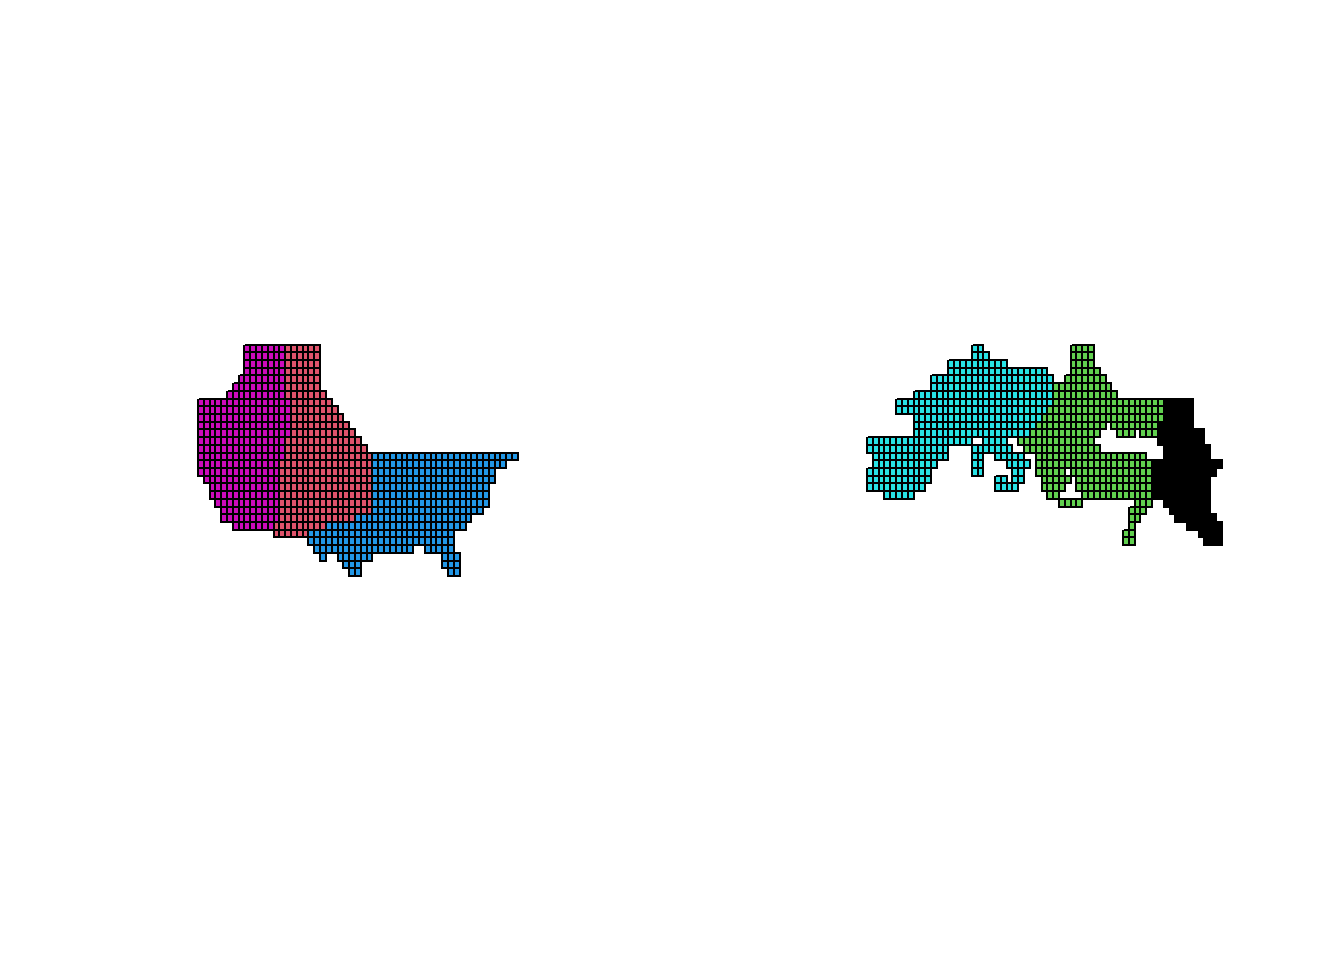

In [ ]:
## Load grided data on regions of north america and europe
reg_gridded <- st_read("DATA/regions_gridded/Data_RegionsGridded.shp")


Let’s now make a geographical linkage between the two datasets, but first correct the coordinates of the fossil dataset with tecnonic plate movement. Using the method of Merdith et al., 2021

In [ ]:
fossil <- palaeorotate(occdf = fossil, age = "midpoint_time", lat = "LAT", lng = "LONG", method = 'grid')
fossil_dat <- st_as_sf(fossil, coords = c('rot_lng', 'rot_lat'), remove = F, crs = 4326)


In [ ]:
fossil_dat <- readRDS("DATA/out/fossil_data_cleaned_geo_corrected.rds")


In [ ]:
# convert fosil data to a geographic object


# apply spatial filter to add region info to fossil data

subset_fossil <- fossil_dat[lengths(st_intersects(fossil_dat,reg_gridded)) > 0,] 

## add spatial info to the fossil dataset 

subset_fossil$region <- reg_gridded$Region[st_intersects(fossil_dat,reg_gridded) |> unlist()]

subset_fossil$WorldMapID <- reg_gridded$WorldMapID[st_intersects(fossil_dat,reg_gridded) |> unlist()]


Let’s visualize geographical sampling completeness for all time-periods

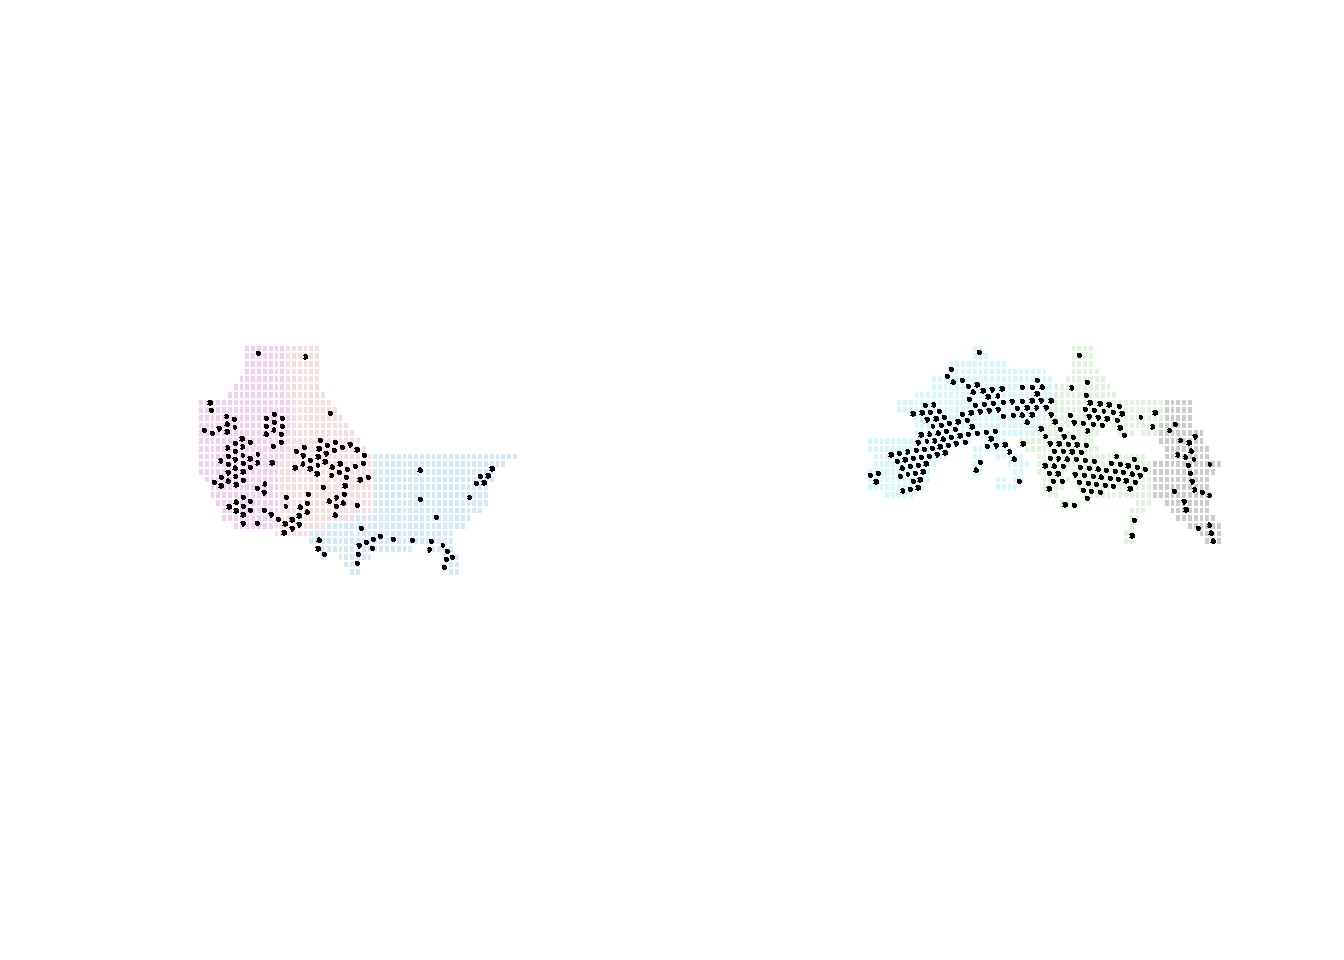

In [ ]:
## Observe the result 

plot(reg_gridded$geometry, 
     col = scales::alpha(as.numeric(as.factor(reg_gridded$Region)), 0.2), 
     border = 0 )
subset_fossil$geometry |> plot(add = T, pch = 6, cex = 0.2, col = 'black')
subset_fossil$geometry |> plot(add = T, pch = 2, cex = 0.2, col = 'black')


Let’s visualize geographical sampling completeness for each time period

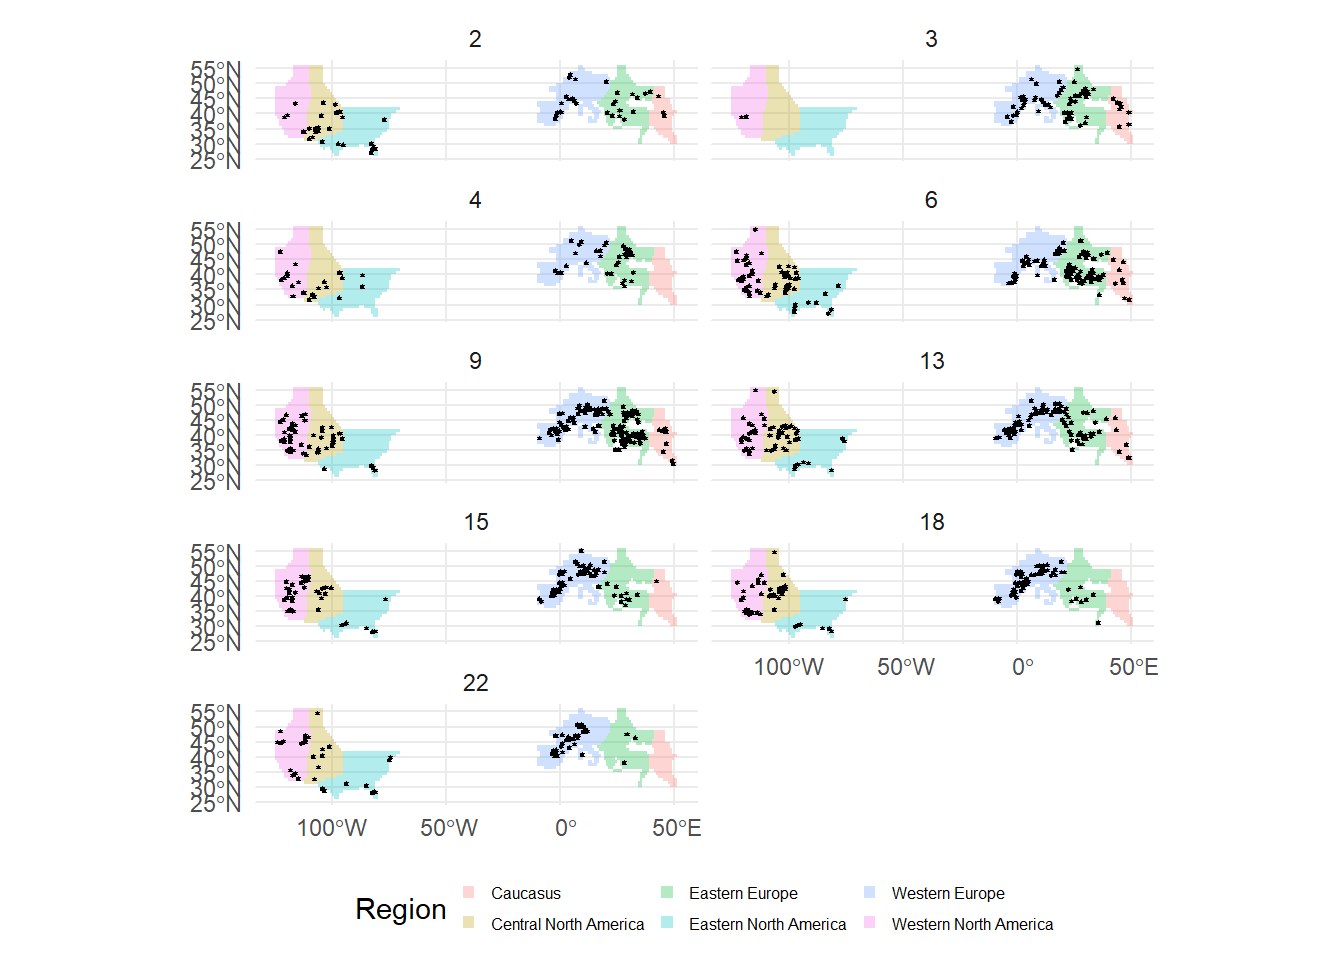

In [ ]:
subset_fossil |>
  group_by(rot_age) |> 
  summarize(nloc = n_distinct(geometry)) |> 
  ggplot() + 
  geom_sf(data  = reg_gridded,
          aes(fill = Region), alpha = 0.3, size = 0.3, color = NA) + 
  facet_wrap(~rot_age, ncol = 2) + 
  theme_minimal()  + 
  geom_sf( shape = 24, fill = 'black', size = 0.2,  col = 'black') + 
  geom_sf( shape = 6, fill = 'black', col = 'black', size = 0.2) +
   theme(legend.position = "bottom", legend.direction = "horizontal", 
             legend.key.size = unit(0.2, "cm"),  # Adjust the size of the legend keys
    legend.text = element_text(size = 6) ) # Adjust the text size in the legend)


It looks evenly spread! Let’s keep the \`rot_age:rotated age\`\` as our reference variable for the temporal axis. Let’s redefine the periods based on this axis.

In [ ]:
subset_fossil <- 
subset_fossil |> 
  mutate(midpoint_period = change_time_to_period(rot_age), 
         hex_id = paste(rot_lng, rot_lat))


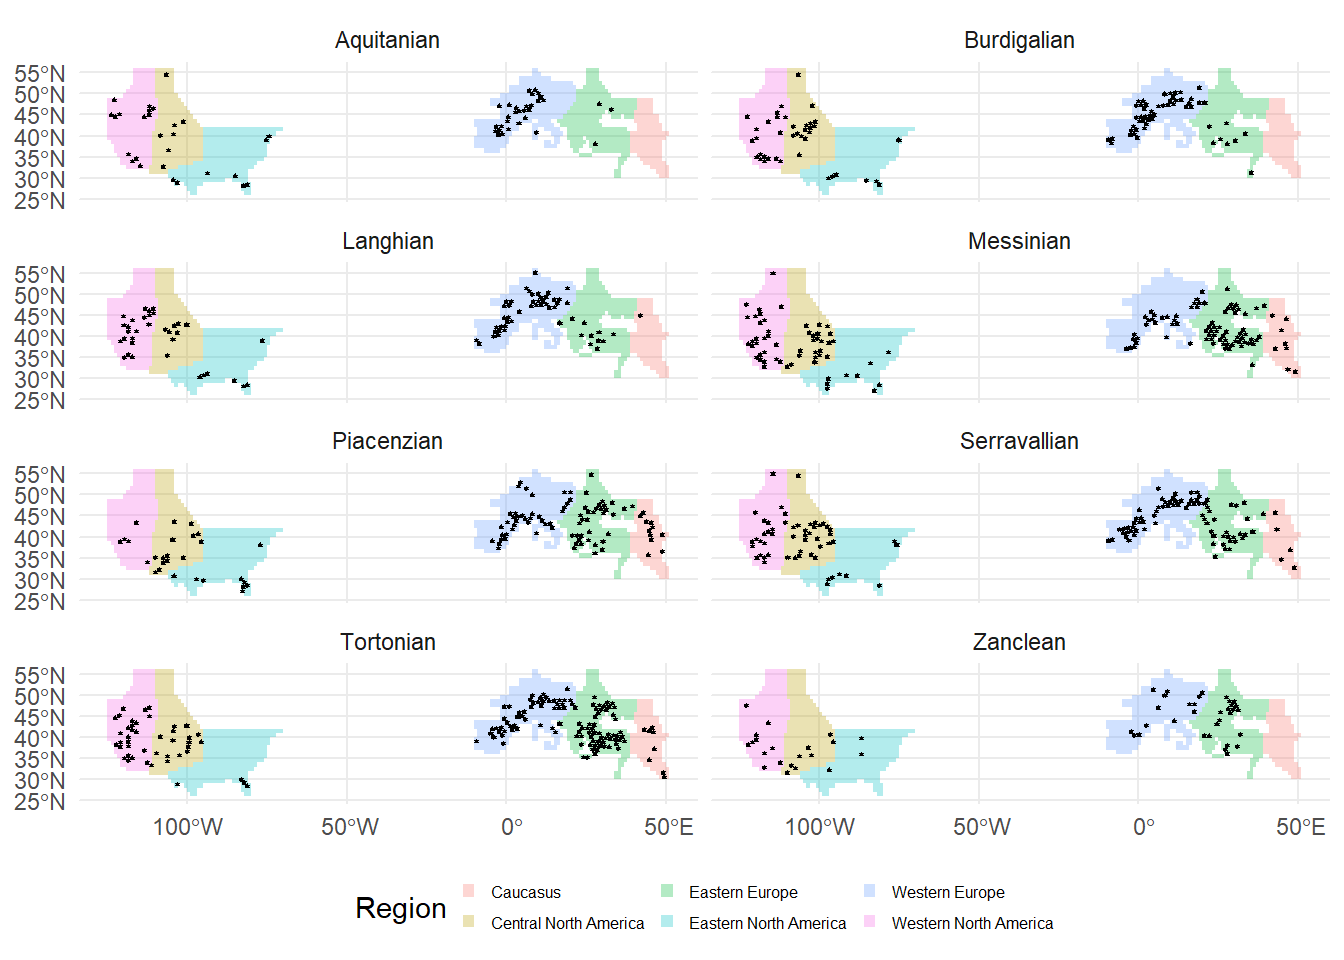

In [ ]:
subset_fossil |>
  group_by(midpoint_period) |> 
  summarize(nloc = n_distinct(geometry)) |> 
  ggplot() +
 geom_sf(data  = reg_gridded,
          aes(fill = Region), alpha = 0.3, size = 0.3, color = NA) + 
  facet_wrap(~midpoint_period, ncol = 2) + 
  theme_minimal()  + 
  geom_sf( shape = 24, fill = 'black', size = 0.2,  col = 'black') + 
  geom_sf( shape = 6, fill = 'black', col = 'black', size = 0.2) +
   theme(legend.position = "bottom", legend.direction = "horizontal", 
             legend.key.size = unit(0.2, "cm"),  # Adjust the size of the legend keys
    legend.text = element_text(size = 6) ) # Adjust the text size in the legend)


Aggregating hex bins to gridded paleocommunities

In [ ]:
xydat <- subset_fossil %>% 
distinct(geometry)
xydat <- st_as_sf(xydat, 
                  coords = c('rot_lng', 'rot_lat'), 
                  crs = 4326)

grid_5 <- st_make_grid(xydat, cellsize = 5) |> st_sf()


Let’s define a function that matches the focal grids with the fossil sampling locations

In [ ]:
assign_grid_id <- function(xydat, grid){


my_list <- st_intersects(xydat, grid)
my_list[lengths(my_list) == 0] <- NA

return(unlist(my_list, use.names = FALSE))

}


In [ ]:
subset_fossil <- 
subset_fossil |> 
  mutate(grid_id_5  = assign_grid_id(geometry, grid_5))


In [ ]:
## summarize sampling intensity and richness

subset_fossil_summary <- 
subset_fossil |>
  group_by(midpoint_period, grid_id_5) |> 
  summarize(sampling_intensity = n_distinct(LIDNUM), 
            genus_richness = n_distinct(GENUS)) |> 
  arrange(sampling_intensity) 


`summarise()` has grouped output by 'midpoint_period'. You can override using
the `.groups` argument.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'

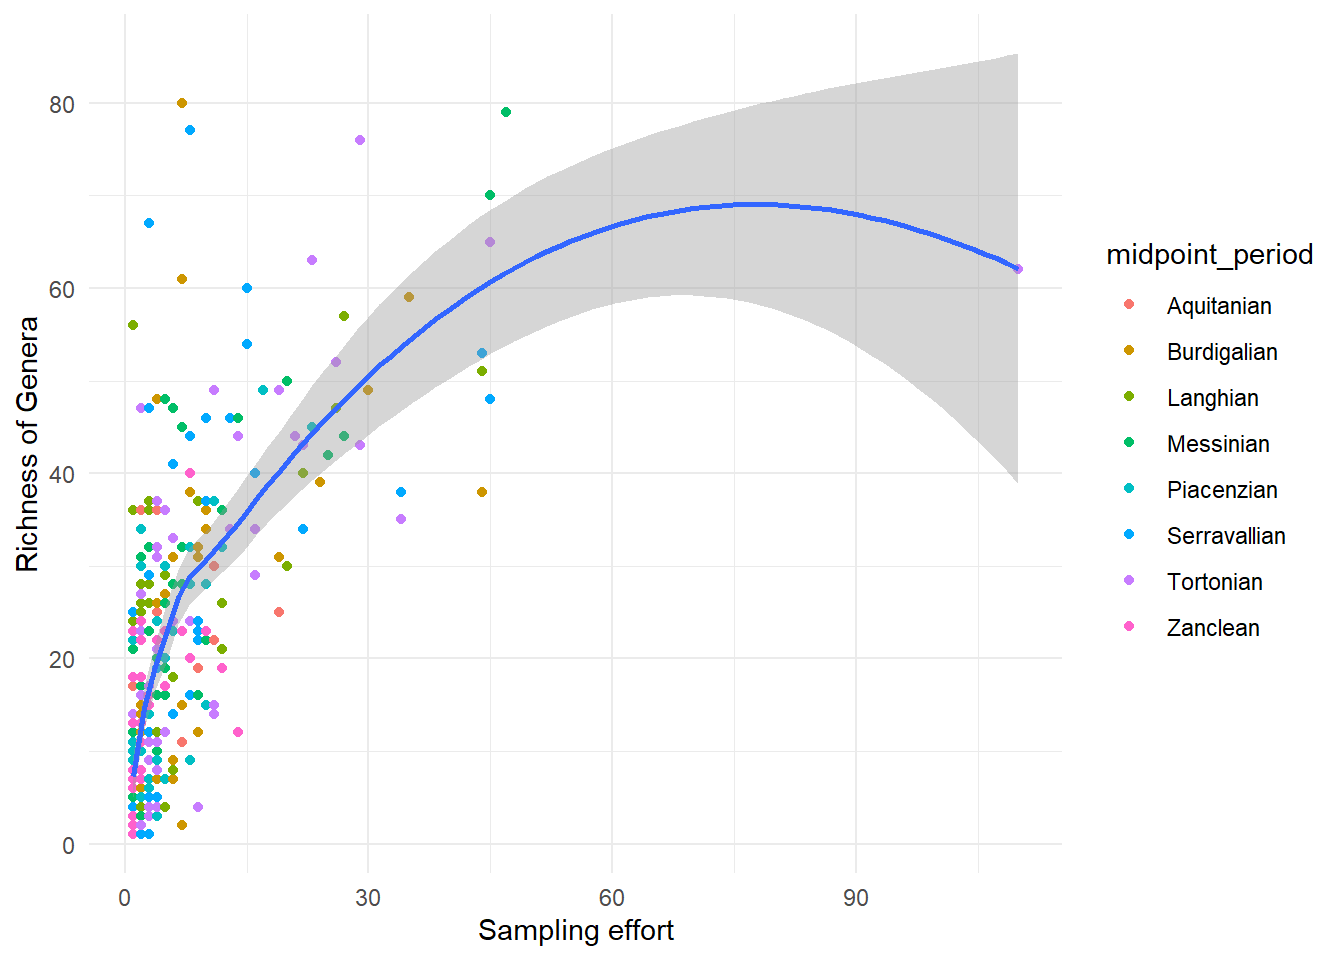

In [ ]:
subset_fossil_summary |>
  ggplot() + 
  geom_point(aes(x = sampling_intensity, 
                 y = genus_richness, 
                 color = midpoint_period)) + 
  geom_smooth(aes(x = sampling_intensity, 
                 y = genus_richness)) + 
  theme_minimal() + 
  xlab('Sampling effort') + 
  ylab('Richness of Genera')


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'

Warning in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,
: pseudoinverse used at 0.91

Warning in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,
: neighborhood radius 3.09

Warning in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,
: reciprocal condition number 1.0849e-16

Warning in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,
: There are other near singularities as well. 9

Warning in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x
else if (is.data.frame(newdata))
as.matrix(model.frame(delete.response(terms(object)), : pseudoinverse used at
0.91

Warning in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x
else if (is.data.frame(newdata))
as.matrix(model.frame(delete.response(terms(object)), : neighborhood radius
3.09

Warning in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x
else if (is.data.frame(newdata))
as.matrix(model.frame(delete.response(terms(object)), : reciprocal condition
number 1.0849e-16

Warning in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x
else if (is.data.frame(newdata))
as.matrix(model.frame(delete.response(terms(object)), : There are other near
singularities as well. 9

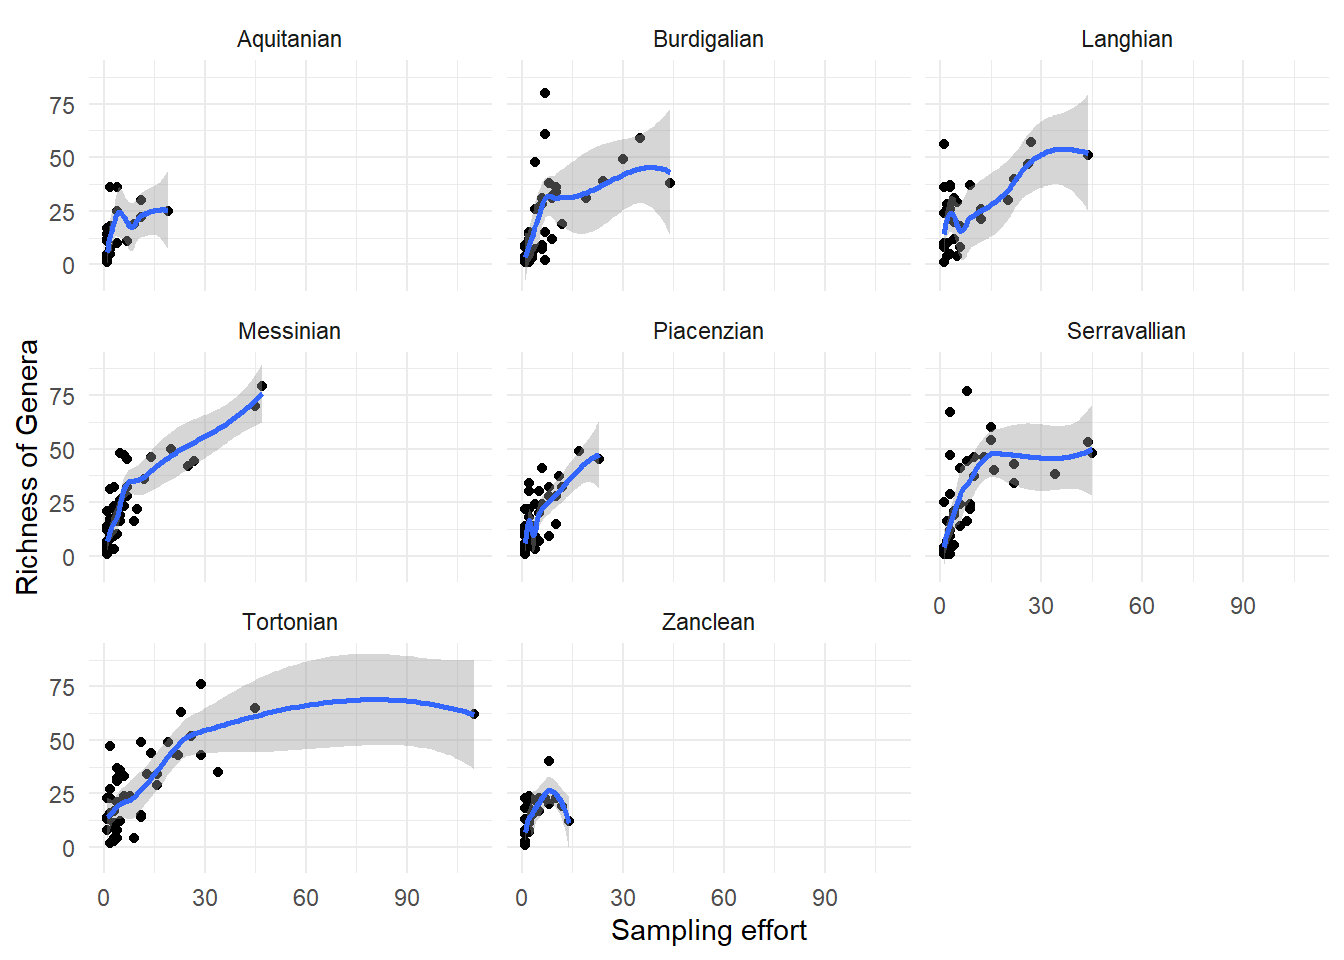

In [ ]:
subset_fossil_summary |>
  ggplot() + 
  geom_point(aes(x = sampling_intensity, 
                 y = genus_richness)) + 
  facet_wrap(~midpoint_period) + 
  geom_smooth(aes(x = sampling_intensity, 
                 y = genus_richness)) + 
  theme_minimal() + 
  xlab('Sampling effort') + 
  ylab('Richness of Genera')


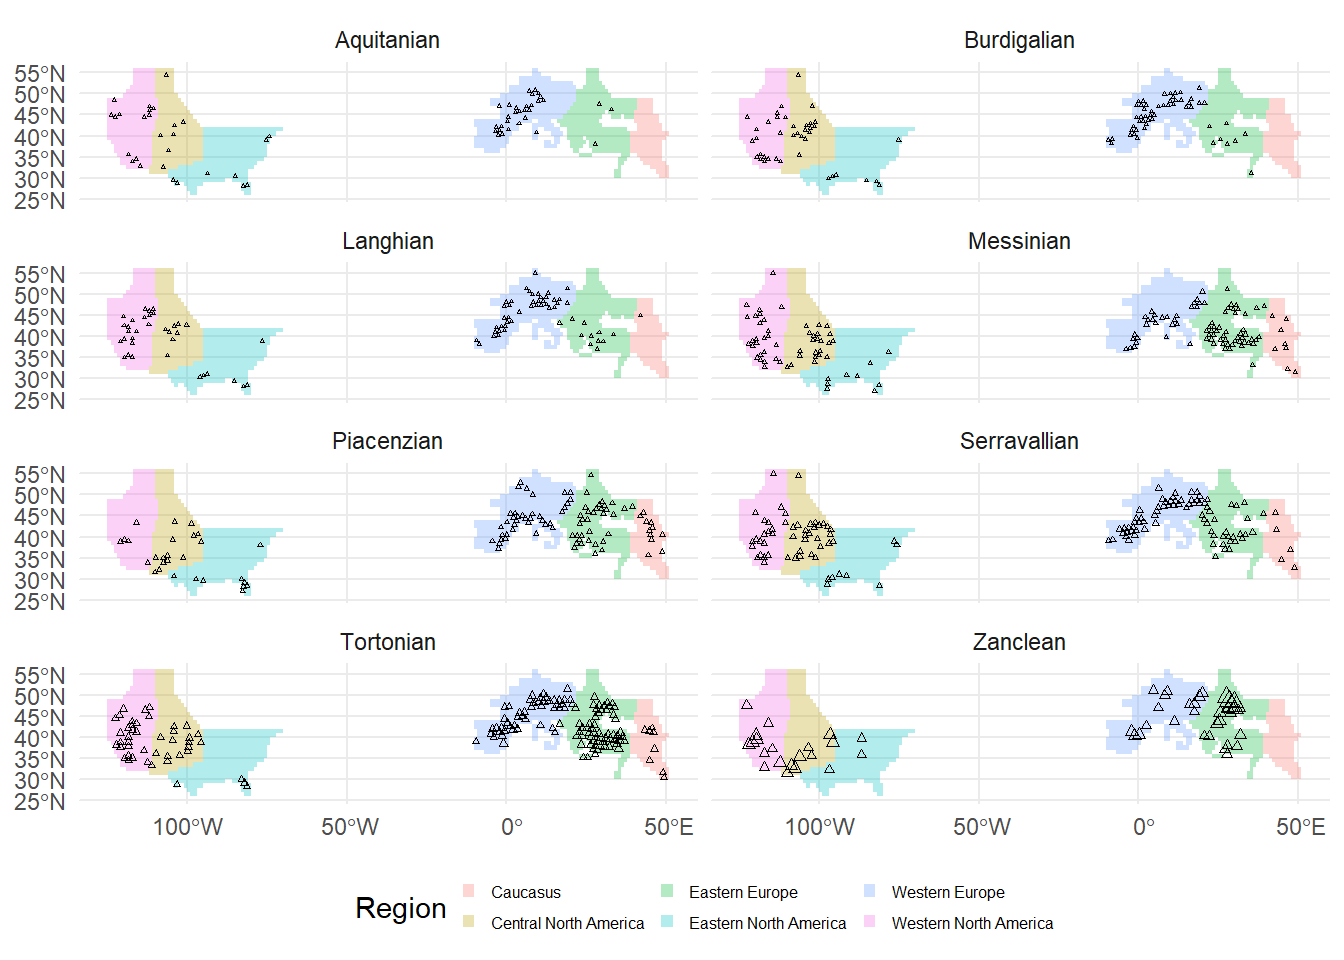

In [ ]:
subset_fossil_summary  |>
  ggplot() +
 geom_sf(data  = reg_gridded,
          aes(fill = Region), alpha = 0.3, size = 0.3, color = NA) + 
  facet_wrap(~midpoint_period, ncol = 2) + 
  theme_minimal()  + 
  geom_sf( shape = 24,  size = sqrt(subset_fossil_summary$sampling_intensity)/5,  col = 'black') + 
   theme(legend.position = "bottom", legend.direction = "horizontal", 
             legend.key.size = unit(0.2, "cm"),  # Adjust the size of the legend keys
    legend.text = element_text(size = 6) ) # Adjust the text size in the legend)


## Taxonomic coverage per time period

In [ ]:
library(ggraph)



Attaching package: 'tidygraph'

The following object is masked from 'package:stats':

    filter

#### Aquitanian

``` r
make_dendro(subset_fossil[subset_fossil$midpoint_period == 'Aquitanian', ])
```

    Multiple parents. Unfolding graph

    Warning: Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
    ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.

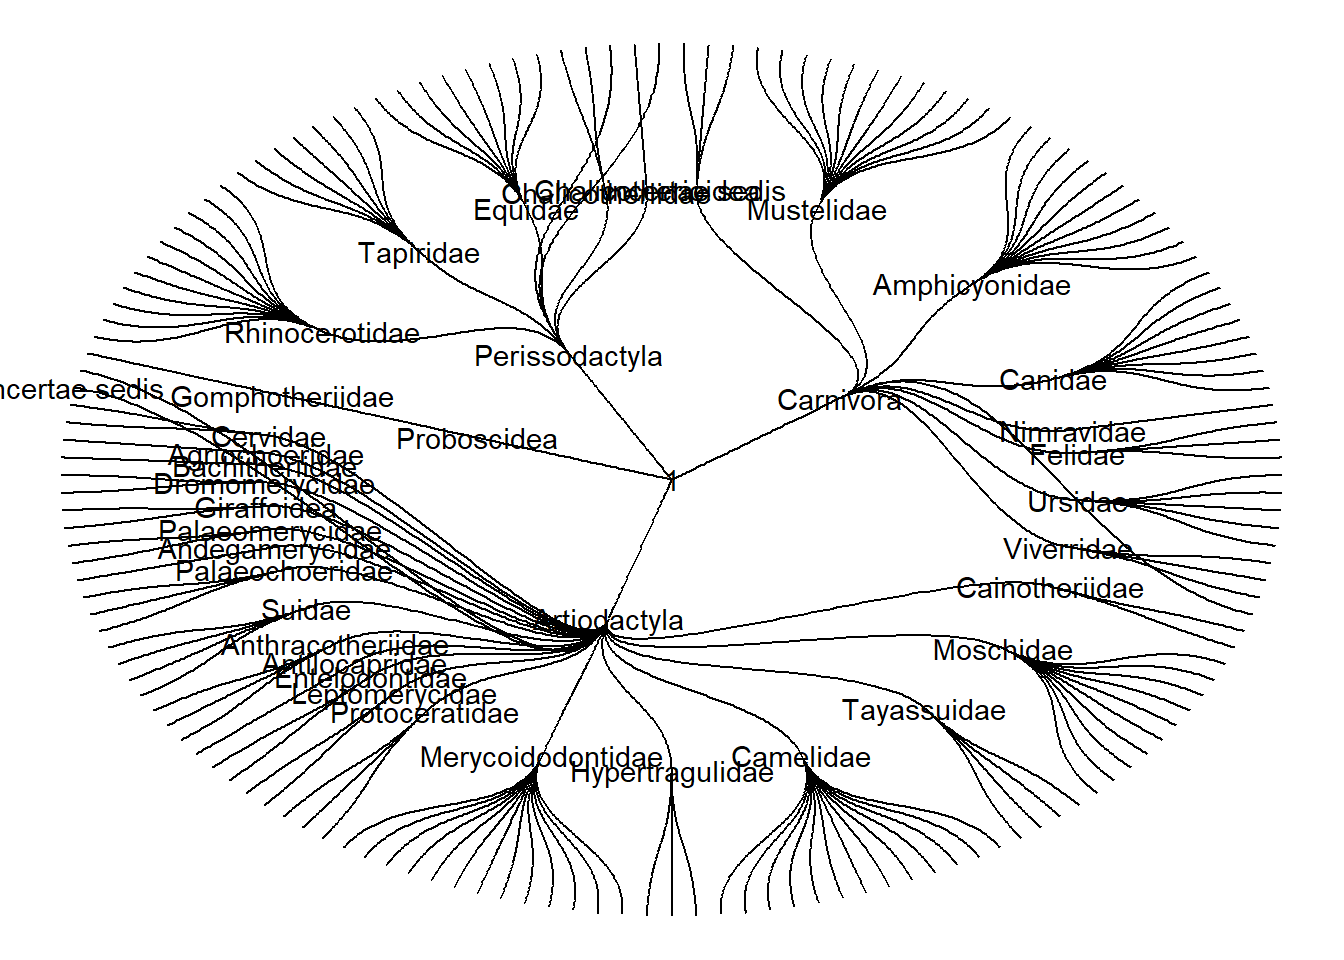

#### Burdigalian

``` r
make_dendro(subset_fossil[subset_fossil$midpoint_period == 'Burdigalian', ])
```

    Multiple parents. Unfolding graph

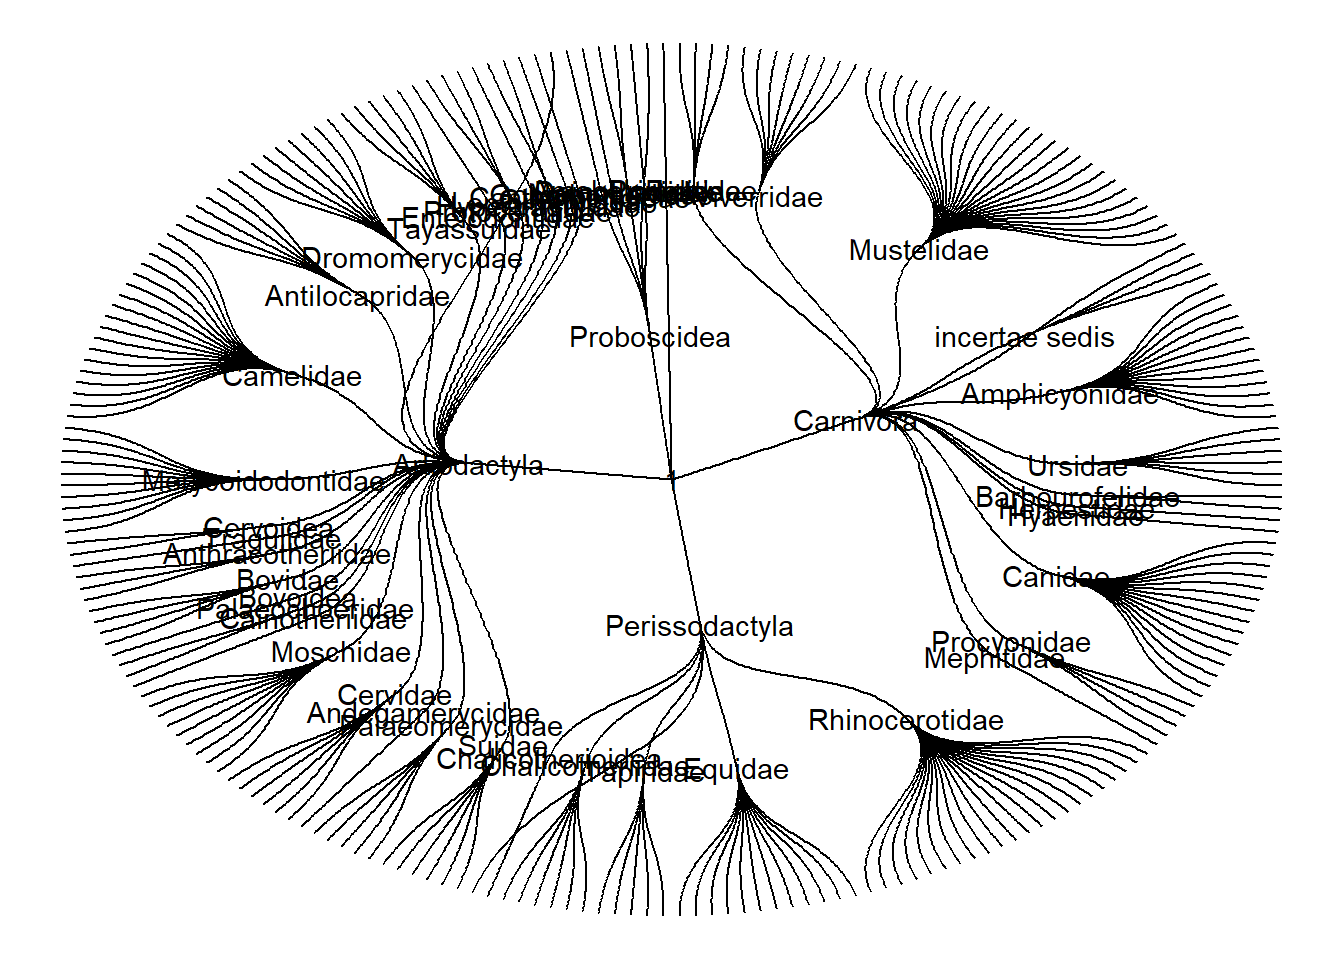

#### Langhian

``` r
make_dendro(subset_fossil[subset_fossil$midpoint_period == 'Langhian', ])
```

    Multiple parents. Unfolding graph

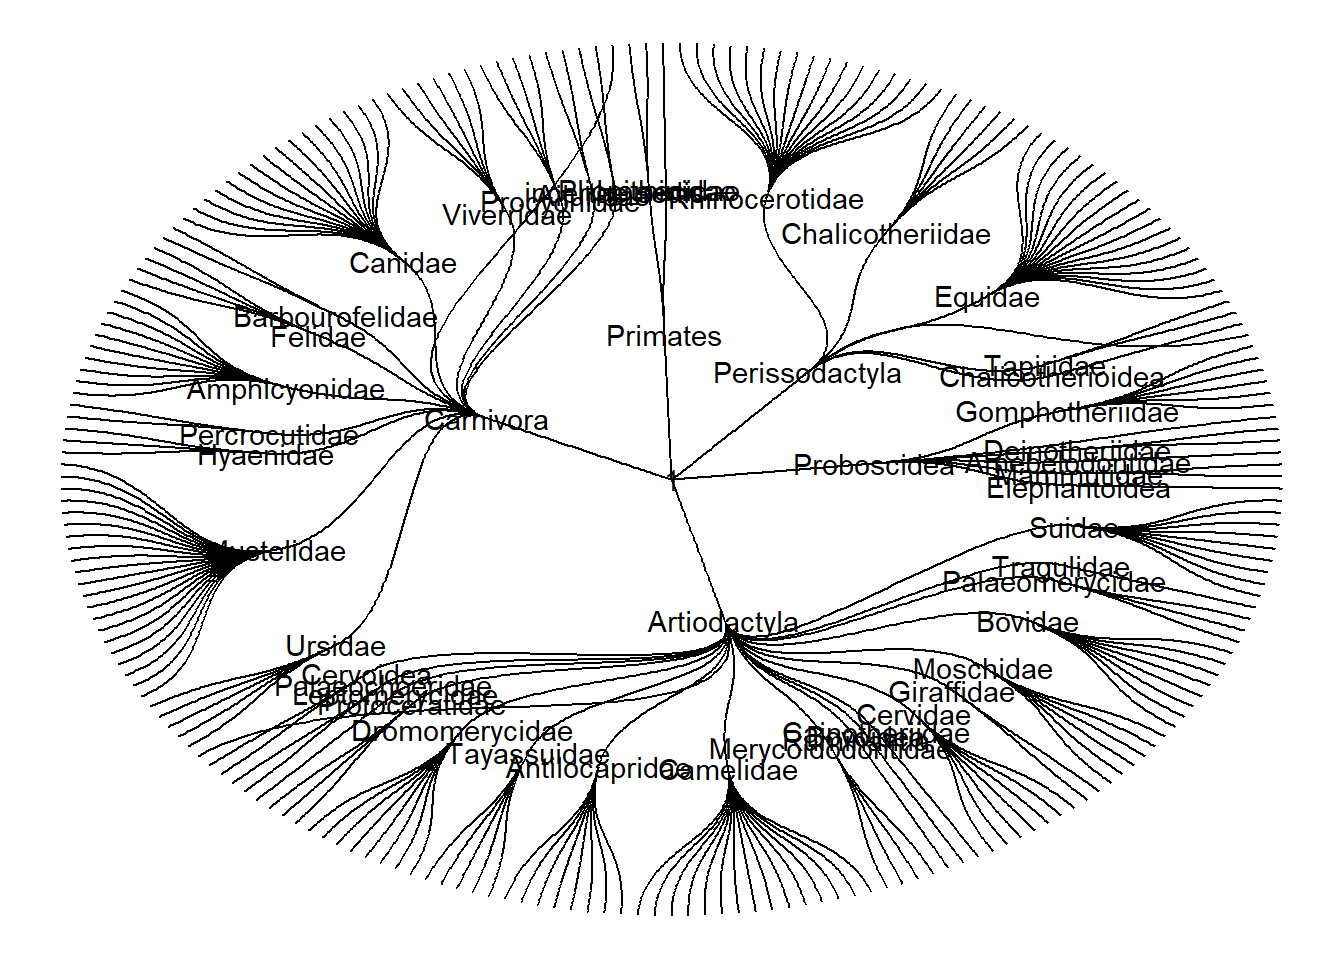

#### Serravallian

``` r
make_dendro(subset_fossil[subset_fossil$midpoint_period == 'Serravallian', ])
```

    Multiple parents. Unfolding graph

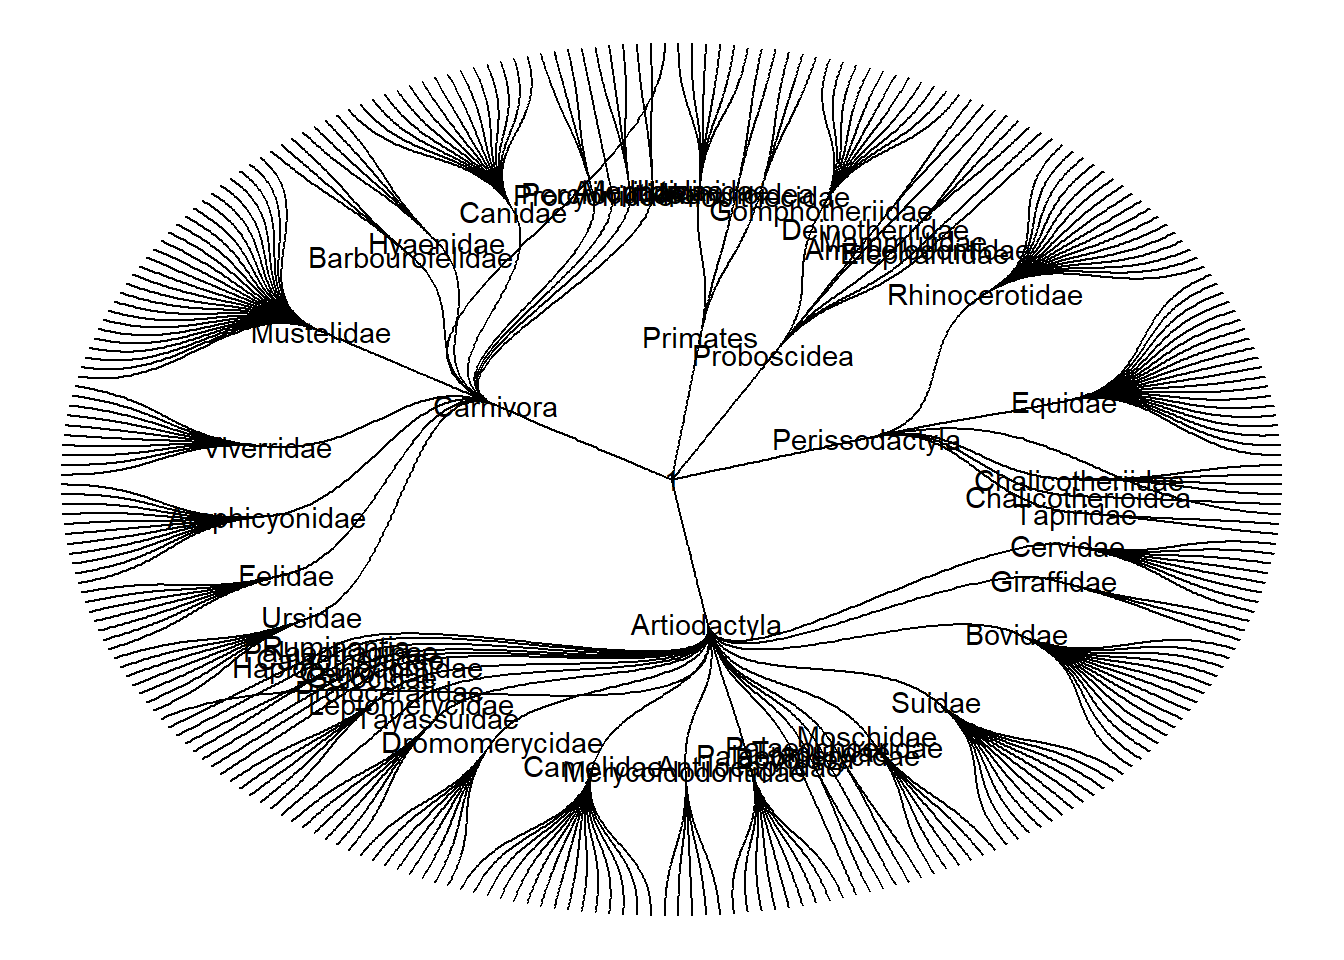

#### Tortonian

``` r
make_dendro(subset_fossil[subset_fossil$midpoint_period == 'Tortonian', ])
```

    Multiple parents. Unfolding graph

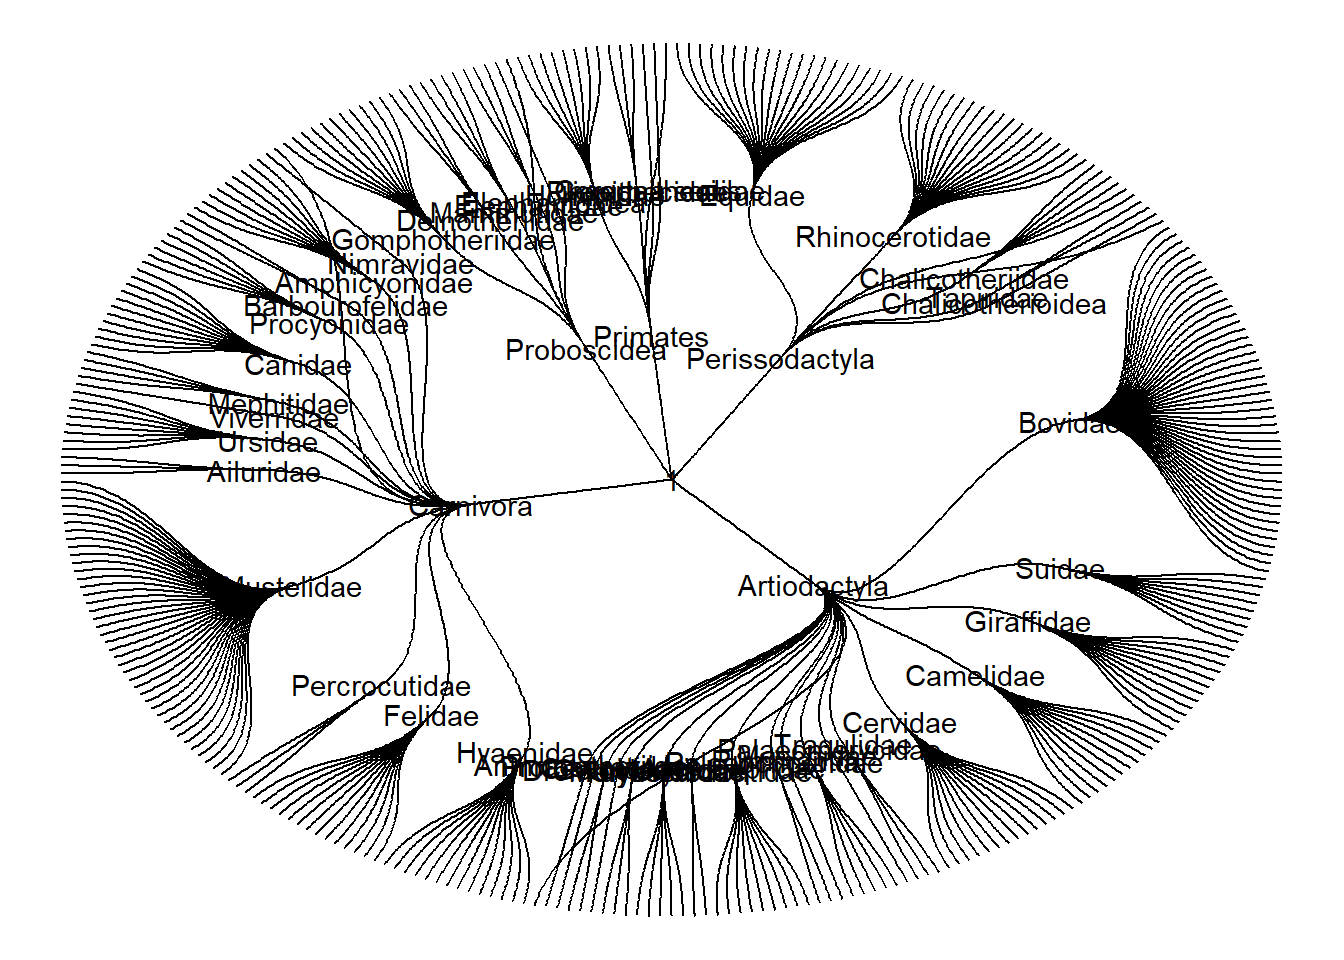

#### Messinian

``` r
make_dendro(subset_fossil[subset_fossil$midpoint_period == 'Messinian', ])
```

    Multiple parents. Unfolding graph

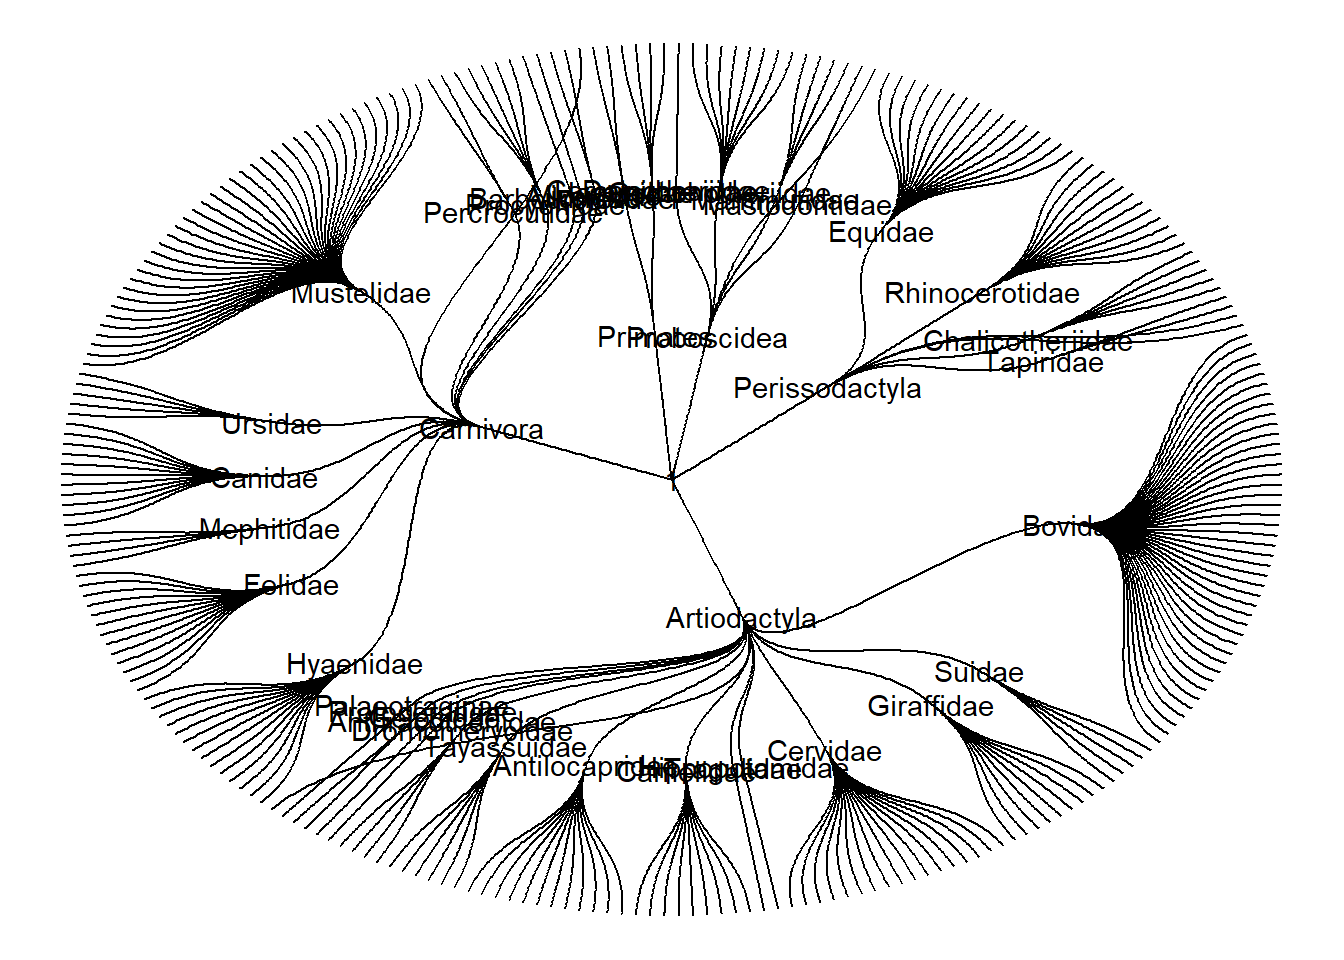

#### Zanclean

``` r
make_dendro(subset_fossil[subset_fossil$midpoint_period == 'Zanclean', ])
```

    Multiple parents. Unfolding graph

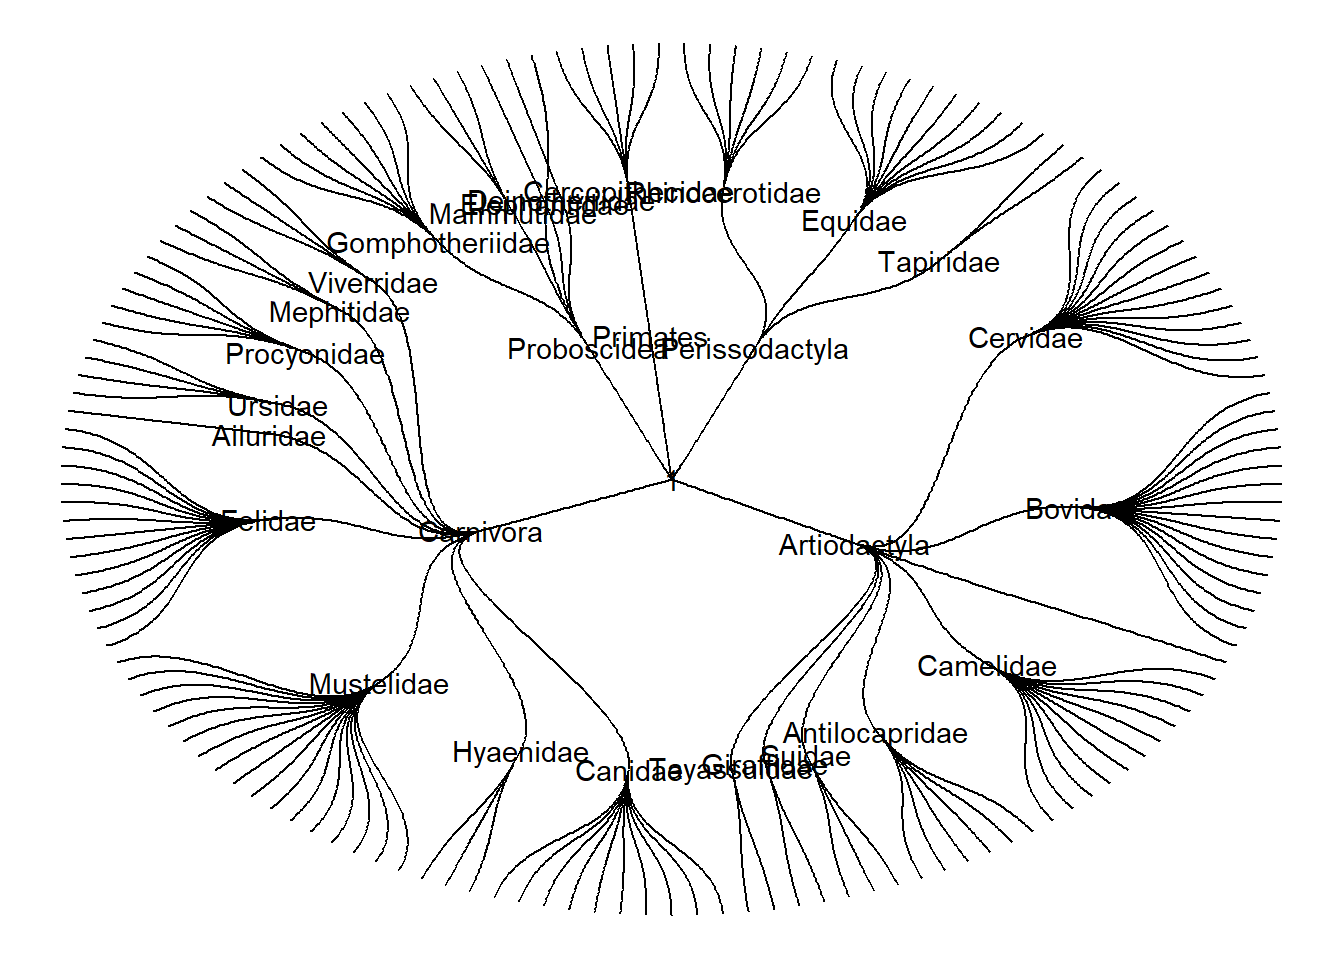

#### Piacenzian

``` r
make_dendro(subset_fossil[subset_fossil$midpoint_period == 'Piacenzian', ])
```

    Multiple parents. Unfolding graph

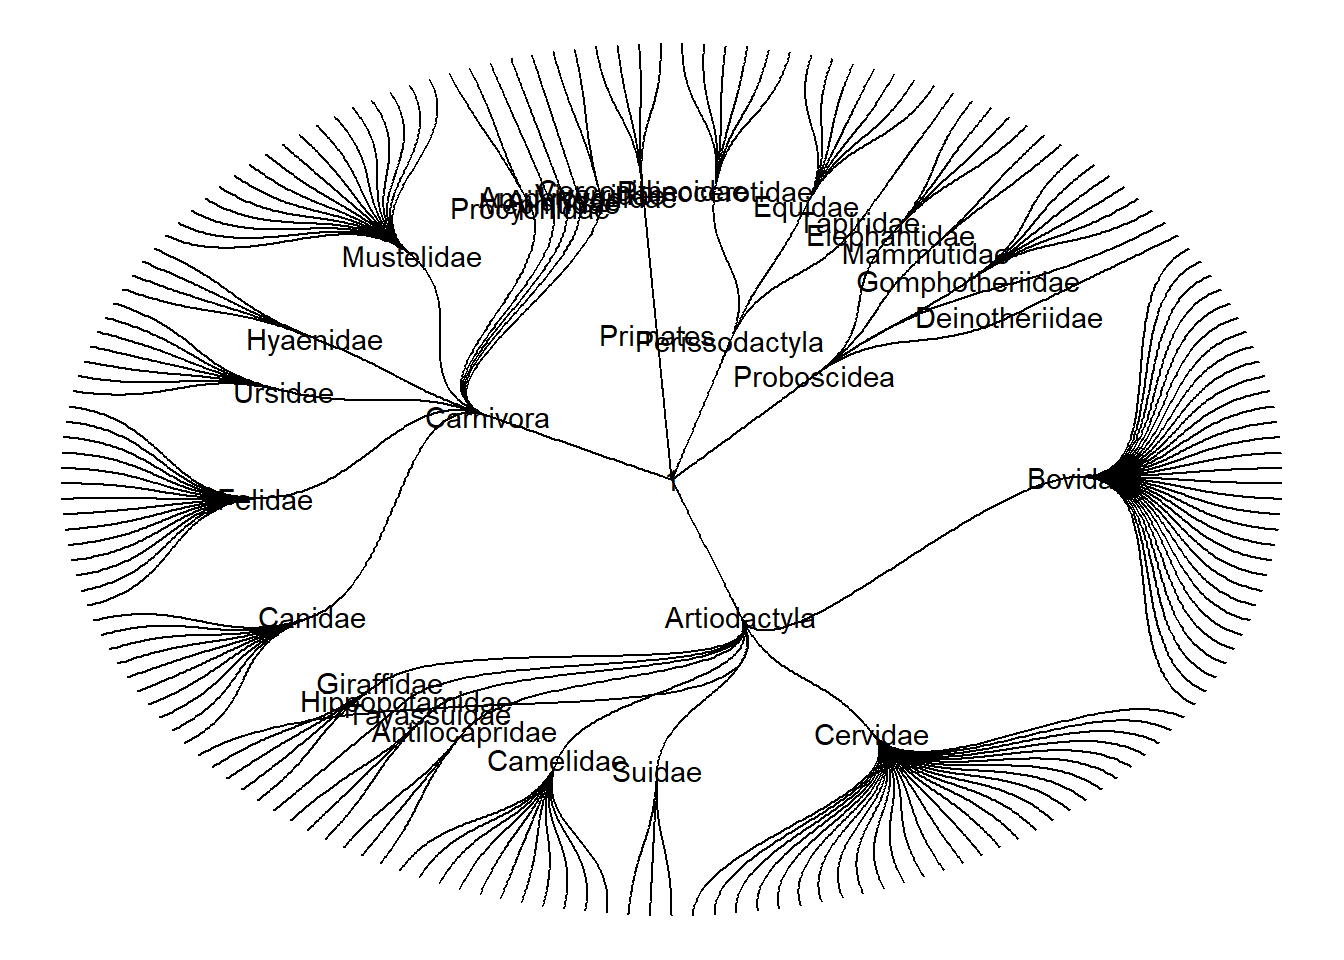

Seems like a balanced distribution of GENUS across time periods, with no extreme changes in the information available.

We can also spot the presence of `indet.` & `incertae sedis` data in the dataset. Those records may correspond to unidentified species or something else. But we will find and remove them from the dataset at the GENUS LEVEL.

In [ ]:
library(stringr)

to_rem <- 
which(
str_detect(subset_fossil$GENUS, 'indet|incertae') | str_detect(subset_fossil$FAMILY, 'indet|incertae') | str_detect(subset_fossil$SPECIES, 'indet|incertae')
) 



# remove indetermined genus 

subset_fossil <- subset_fossil[-to_rem,]


After this cleaning steps, lets count the number of species per grid and remain only with the grids-periods of time pairs with at least `5` species each.

In [ ]:
subset_fossil <- subset_fossil |> mutate(sp_id = paste0(GENUS,"_", SPECIES))


subset_fossil$gr_id <- as.numeric(is.numeric(subset_fossil$grid_id_5))

# 
grid_wt_enough_data <- 
subset_fossil |> 
group_by(region, midpoint_period ) |> 
summarize(n_sp  = n_distinct(sp_id), 
n_gen = n_distinct(GENUS))  |> 
filter(n_sp > 5)


`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.

let’s now filter the fossil dataset based on those grid ids

In [ ]:
subset_fossil <- 
subset_fossil |> 
filter(paste(region, midpoint_period) %in% 
paste(grid_wt_enough_data$region, grid_wt_enough_data$midpoint_period))


Finally, let’s count the dimensions of our dataset

In [ ]:
subset_fossil |> dim()


[1] 11066    26

In [ ]:
saveRDS(subset_fossil, 'DATA/out/fossil_data_cleaned.rds')


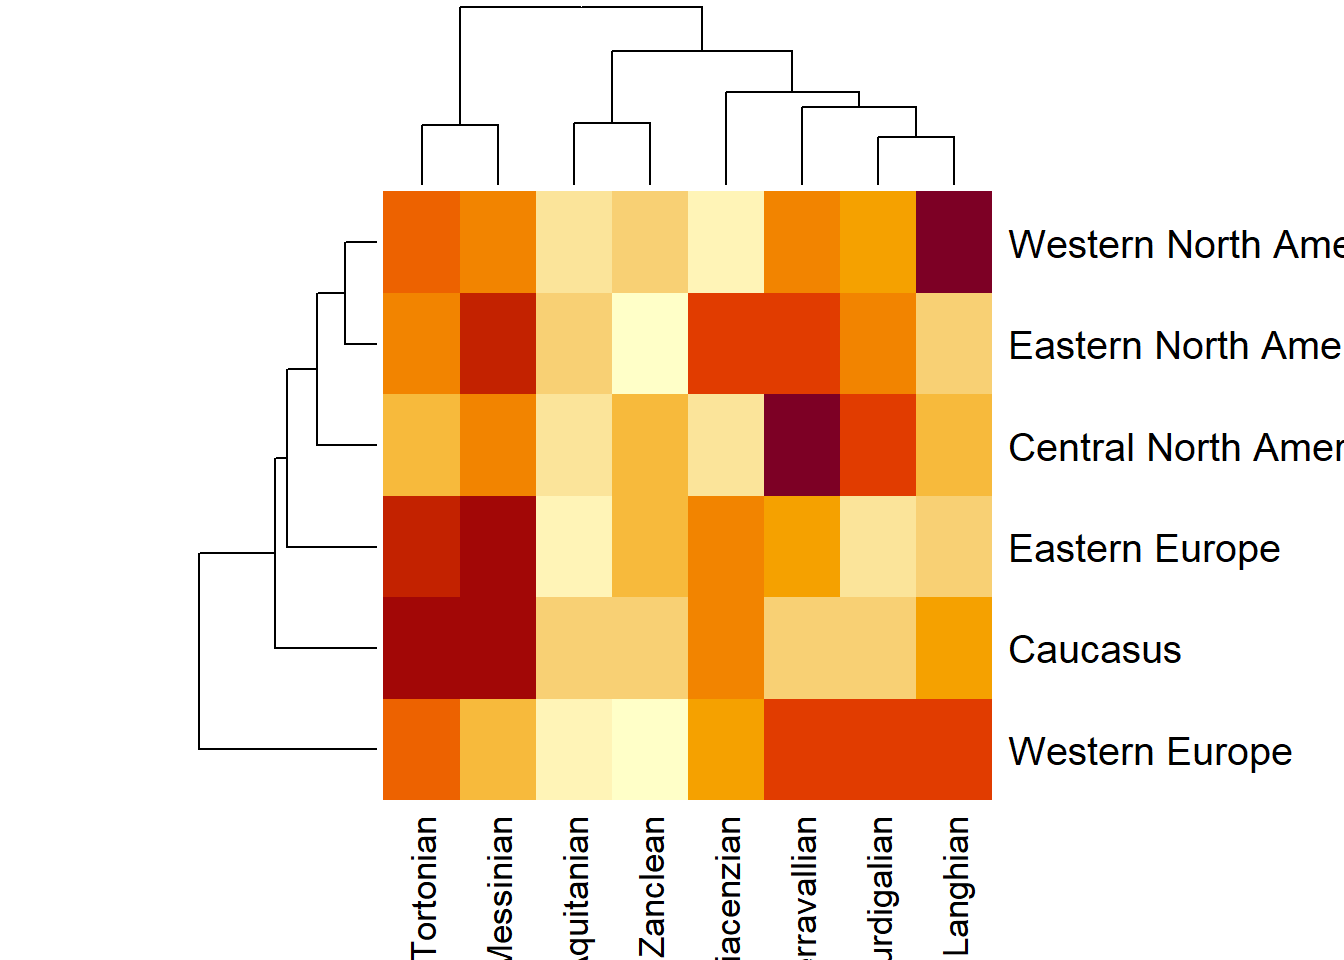

In [ ]:
#|

## number of records per region and time  
xtabs(gr_id ~ region + midpoint_period, subset_fossil) |> sqrt() |> heatmap()


We can observe that regions are relatively equally sample in space, but not in time. Particularly, the periods `Aquitanian`, `Zanclean`, `Serravallian` and `Piacenzian` seem to be relatively less well sampled

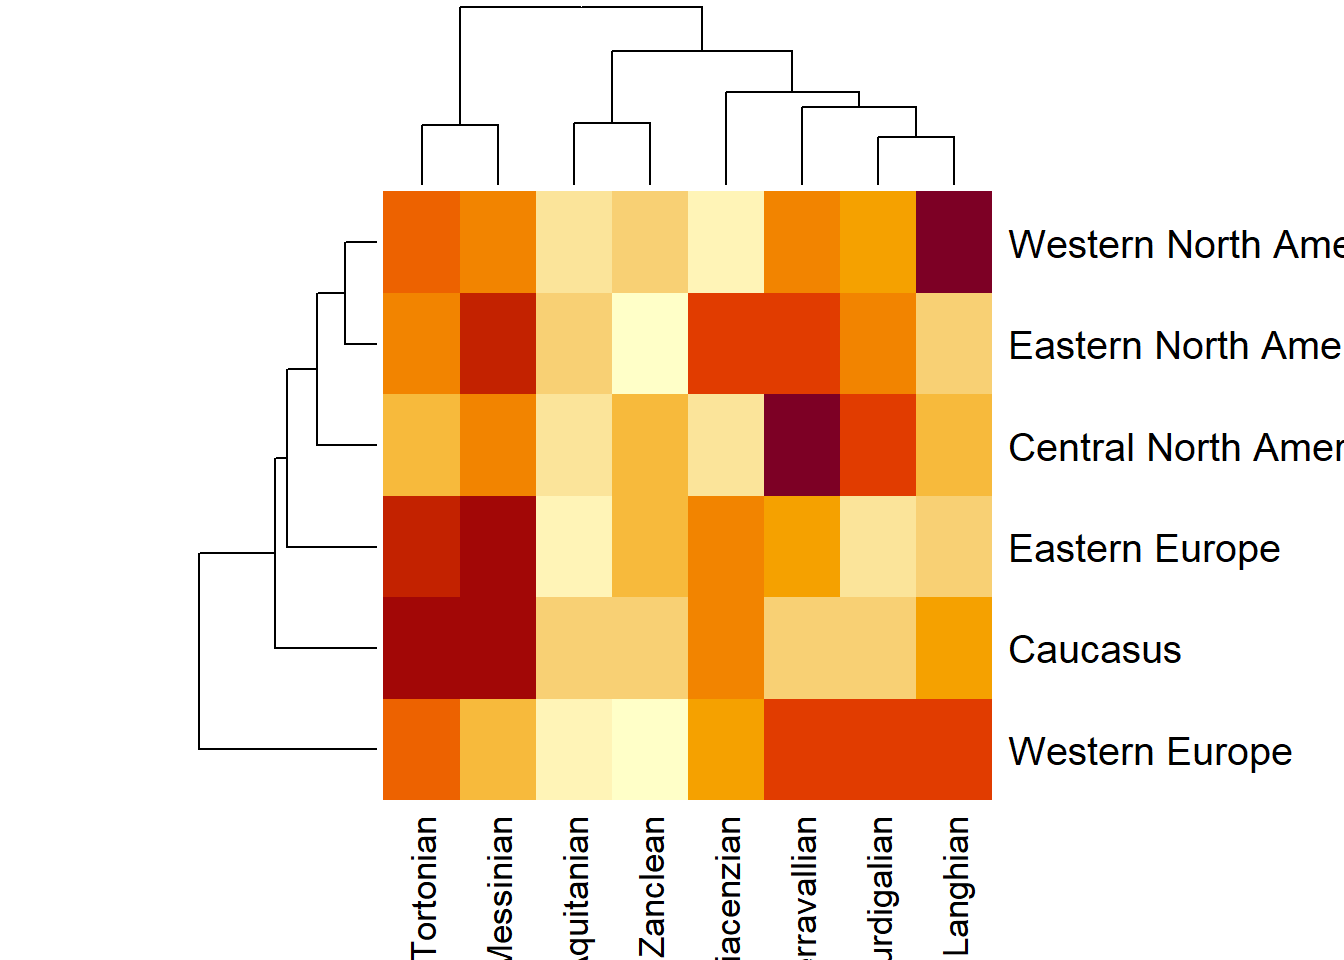

In [ ]:
# number of species per region and time  
xtabs(ifelse(is.na(subset_fossil$sp_id),0,1) ~ region + midpoint_period, subset_fossil) |> sqrt() |> heatmap()


We observe that the species richness patterns follows the sampling effort pattern. We should address this covariance in our modelling approaches.